CREDIT: https://pythonprogramming.net/custom-environment-reinforcement-learning-stable-baselines-3-tutorial/?completed=/saving-and-loading-reinforcement-learning-stable-baselines-3-tutorial/

https://towardsdatascience.com/snake-played-by-a-deep-reinforcement-learning-agent-53f2c4331d36
https://github.com/henniedeharder/snake/blob/master/agent_1.py


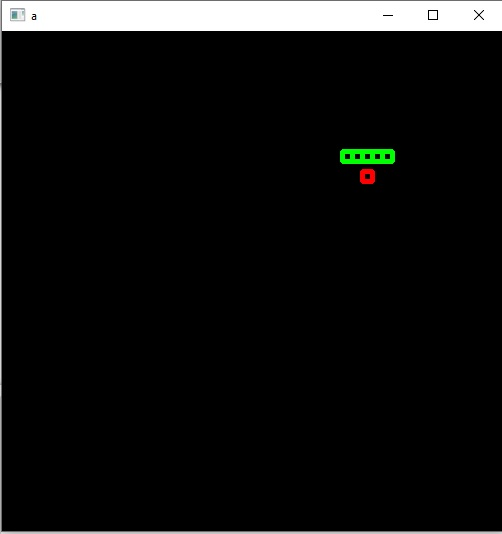

In [1]:
import gym
from gym import spaces
import numpy as np
import cv2
import random
import time
from collections import deque

# The snake game costumized enviroment

In [28]:
def collision_with_apple(apple_position):
    apple_position = [random.randrange(1,50)*10,random.randrange(1,50)*10]
    return apple_position

def collision_with_boundaries(snake_head):
    if snake_head[0]>=500 or snake_head[0]<0 or snake_head[1]>=500 or snake_head[1]<0 :
        return 1
    else:
        return 0

def collision_with_self(snake_position):
    snake_head = snake_position[0]
    if snake_head in snake_position[1:]:
        return 1
    else:
        return 0
    
class SnakeEnv(gym.Env):

    def __init__(self):
        
        super(SnakeEnv, self).__init__()
        
        self.snake_initial_length = 3
        self.action_space = spaces.Discrete(4)
        self.observation_space = spaces.Box(low=0, high=1, shape=(12,), dtype=np.int)
        
        
    def write_video(self):
        fourcc = cv2.VideoWriter_fourcc(*'MP4V')
        self.video = cv2.VideoWriter('snake_game.mp4',fourcc,100.0,(500,500),True)
        
    def render(self, mode='human'):
        
        # Create image
        img = np.zeros((500,500,3),dtype='uint8')        
        # Display Apple
        cv2.rectangle(img,(self.apple_position[0],self.apple_position[1]),(self.apple_position[0]+10,self.apple_position[1]+10),(0,0,255),3)

        # Display Snake
        for position in self.snake_position:
            cv2.rectangle(img,(position[0],position[1]),(position[0]+10,position[1]+10),(0,255,0),3)

        # Display collision text
        if collision_with_boundaries(self.snake_head) == 1 or collision_with_self(self.snake_position) == 1:
            font = cv2.FONT_HERSHEY_SIMPLEX
            self.img = np.zeros((500,500,3),dtype='uint8')
            cv2.putText(img,'Snake length {}'.format(len(self.snake_position)),(140,250), font, 1,(255,255,255),2,cv2.LINE_AA)

        self.video.write(img)
        cv2.imshow('a',img)
        cv2.waitKey(10)
        
    def release(self):
        self.video.release()

    def step(self, action):
        
        # Change the head position based on the button direction
        if action == 1:
            self.snake_head[0] += 10
        elif action == 0:
            self.snake_head[0] -= 10
        elif action == 2:
            self.snake_head[1] += 10
        elif action == 3:
            self.snake_head[1] -= 10

        # Increase snake length on eating apple
        apple_reward = 0.0
        if self.snake_head == self.apple_position:
            self.apple_position = collision_with_apple(self.apple_position)
            self.snake_position.insert(0,list(self.snake_head))
            apple_reward = 10.0 
        else:
            self.snake_position.insert(0,list(self.snake_head))
            self.snake_position.pop()
        
        # On collision, kill the snake
        if collision_with_boundaries(self.snake_head) == 1 or collision_with_self(self.snake_position) == 1:
            self.done = True
            self.reward = -100.0 
        else:
            
            dist_to_apple = self._compute_distance_from_head(self.apple_position)
            distance_reward = 0.0
            if self.prev_distance < dist_to_apple:
                distance_reward = -1
            else:
                distance_reward =  1
            self.prev_distance = dist_to_apple
            
            self.reward = distance_reward + apple_reward

        
        observation = self._compute_observation()
        
        return observation, self.reward, self.done, {}
    
    def _compute_distance_from_head(self, position):
        return abs(self.snake_head[0]-position[0]) + abs(self.snake_head[1]-position[1])
        

    def reset(self):

        # Initial Snake and Apple position
        self.snake_position = [[250,250],[240,250],[230,250]]
        self.apple_position = [random.randrange(1,50)*10,random.randrange(1,50)*10]
        self.snake_head = [250,250]
        self.prev_distance = self._compute_distance_from_head(self.apple_position)
        
        self.prev_total_reward = 0.0
            
        self.done = False
        observation = self._compute_observation()
        
        return observation
        

    def _compute_observation(self):
        
        head_x = self.snake_head[0]
        head_y = self.snake_head[1]
        apple_x = self.apple_position[0] 
        apple_y = self.apple_position[1] 
        
        apple_above = 1 if apple_y > head_y else 0
        apple_below = 1 if apple_y < head_y else 0
        apple_left = 1 if apple_x > head_x else 0
        apple_right = 1 if apple_x < head_x else 0
        
        wall_up = 1 if head_y > 250.0 else 0
        wall_down = 1 if head_y < 250.0 else 0
        wall_right = 1 if head_x > 250.0 else 0
        wall_left = 1 if head_x < 250.0 else 0
        
        # body close
        body_up = []
        body_right = []
        body_down = []
        body_left = []
        if len(self.snake_position) > 3:
            for body in self.snake_position[3:]:
                if self._compute_distance_from_head(body) == 10:
                    if body[1] < self.snake_head[1]:
                        body_down.append(1)
                    elif body[1] > self.snake_head[1]:
                        body_up.append(1)
                    if body[0] < self.snake_head[0]:
                        body_left.append(1)
                    elif body[0] > self.snake_head[0]:
                        body_right.append(1)
                        
        if len(body_up) > 0: body_up = 1
        else: body_up = 0
            
        if len(body_right) > 0: body_right = 1
        else: body_right = 0
            
        if len(body_down) > 0: body_down = 1
        else: body_down = 0
            
        if len(body_left) > 0: body_left = 1
        else: body_left = 0

        observation = [apple_above,apple_below,apple_left,apple_right,
                       wall_up,wall_down,wall_right,wall_left,
                       body_up,body_right,body_down,body_left] 
        observation = np.array(observation)
        
        return observation

In [24]:
env = SnakeEnv()
episodes = 5

for episode in range(episodes):
    done = False
    obs = env.reset()
    while not done:
        random_action = env.action_space.sample()
        obs, reward, done, info = env.step(random_action)
        #env.render()
        print('reward',reward)

reward 1.0
reward -1.0
reward -100.0
reward 1.0
reward -100.0
reward -1.0
reward -1.0
reward -1.0
reward -100.0
reward -1.0
reward 1.0
reward 1.0
reward -1.0
reward -1.0
reward -1.0
reward 1.0
reward -1.0
reward -1.0
reward 1.0
reward -1.0
reward 1.0
reward 1.0
reward 1.0
reward 1.0
reward -1.0
reward -100.0
reward -100.0


# Use a stable baselines 3 algorithm to compute the optimal policy

In [4]:
import gym
import os
from stable_baselines3 import PPO,A2C,DQN

d:\apps\python_3_8_6\lib\site-packages\setuptools\distutils_patch.py:25: UserWarning: Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first.
  warnings.warn(


In [5]:
env = SnakeEnv()

In [6]:
model_name = "PPO"
models_dir = "models/" + model_name
logdir = "logs"

In [7]:
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

if not os.path.exists(logdir):
    os.makedirs(logdir)

## Save models at different iterations

In [8]:
env.reset()
if model_name =="PPO":
    model = PPO('MlpPolicy', env, verbose=1, tensorboard_log=logdir)
elif model_name =="A2C":
    model = A2C('MlpPolicy', env, verbose=1, tensorboard_log=logdir)
elif model_name =="DQN":
    param={}
    param['policy'] = 'MlpPolicy'
    param['env'] = env
    param['verbose'] = 1
    param['tensorboard_log'] = logdir
    
    param['exploration_initial_eps'] = 1 
    param['exploration_final_eps'] = .01
    param['exploration_fraction'] = .995
    param['gamma'] = .95
    param['batch_size'] = 500
    param['learning_rate'] = 0.00025
    param['buffer_size'] = 2500
    model = DQN(**param)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [9]:
TIMESTEPS = 10000
iters = 0
for i in range(50):
    iters += 1
    model.learn(total_timesteps=TIMESTEPS, reset_num_timesteps=False, tb_log_name=model_name)
    model.save(f"{models_dir}/{TIMESTEPS*iters}")

Logging to logs\PPO_0
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.75     |
|    ep_rew_mean     | -100     |
| time/              |          |
|    fps             | 892      |
|    iterations      | 1        |
|    time_elapsed    | 2        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 4.72        |
|    ep_rew_mean          | -99.8       |
| time/                   |             |
|    fps                  | 1006        |
|    iterations           | 2           |
|    time_elapsed         | 4           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.010907151 |
|    clip_fraction        | 0.124       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.38       |
|    explained_variance   | -0.00237    |
|    lea

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 32.9         |
|    ep_rew_mean          | -94.9        |
| time/                   |              |
|    fps                  | 1384         |
|    iterations           | 3            |
|    time_elapsed         | 4            |
|    total_timesteps      | 26624        |
| train/                  |              |
|    approx_kl            | 0.0044269515 |
|    clip_fraction        | 0.0458       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.629       |
|    explained_variance   | 0.184        |
|    learning_rate        | 0.0003       |
|    loss                 | 62.6         |
|    n_updates            | 120          |
|    policy_gradient_loss | -0.00575     |
|    value_loss           | 142          |
------------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_m

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 29.3         |
|    ep_rew_mean          | -77.8        |
| time/                   |              |
|    fps                  | 1298         |
|    iterations           | 4            |
|    time_elapsed         | 6            |
|    total_timesteps      | 49152        |
| train/                  |              |
|    approx_kl            | 0.0047877585 |
|    clip_fraction        | 0.0406       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.357       |
|    explained_variance   | 0.695        |
|    learning_rate        | 0.0003       |
|    loss                 | 43.2         |
|    n_updates            | 230          |
|    policy_gradient_loss | -0.00461     |
|    value_loss           | 87.6         |
------------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 41.8        |
|    ep_rew_mean          | -53.6       |
| time/                   |             |
|    fps                  | 1231        |
|    iterations           | 5           |
|    time_elapsed         | 8           |
|    total_timesteps      | 71680       |
| train/                  |             |
|    approx_kl            | 0.005163873 |
|    clip_fraction        | 0.0544      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.269      |
|    explained_variance   | 0.563       |
|    learning_rate        | 0.0003      |
|    loss                 | 95.4        |
|    n_updates            | 340         |
|    policy_gradient_loss | -0.00468    |
|    value_loss           | 175         |
-----------------------------------------
Logging to logs\PPO_0
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48.1 

Logging to logs\PPO_0
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 108      |
|    ep_rew_mean     | 27       |
| time/              |          |
|    fps             | 2386     |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 94208    |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 113          |
|    ep_rew_mean          | 32.8         |
| time/                   |              |
|    fps                  | 1607         |
|    iterations           | 2            |
|    time_elapsed         | 2            |
|    total_timesteps      | 96256        |
| train/                  |              |
|    approx_kl            | 0.0017987159 |
|    clip_fraction        | 0.0158       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.119       |
|    explained_variance   | 0.208   

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 129         |
|    ep_rew_mean          | 56.8        |
| time/                   |             |
|    fps                  | 1511        |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 116736      |
| train/                  |             |
|    approx_kl            | 0.002302111 |
|    clip_fraction        | 0.0104      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0947     |
|    explained_variance   | 0.123       |
|    learning_rate        | 0.0003      |
|    loss                 | 173         |
|    n_updates            | 560         |
|    policy_gradient_loss | -0.000847   |
|    value_loss           | 461         |
-----------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 123 

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 122          |
|    ep_rew_mean          | 47.3         |
| time/                   |              |
|    fps                  | 1348         |
|    iterations           | 3            |
|    time_elapsed         | 4            |
|    total_timesteps      | 139264       |
| train/                  |              |
|    approx_kl            | 0.0015361889 |
|    clip_fraction        | 0.0188       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0753      |
|    explained_variance   | 0.179        |
|    learning_rate        | 0.0003       |
|    loss                 | 392          |
|    n_updates            | 670          |
|    policy_gradient_loss | -0.00377     |
|    value_loss           | 1.03e+03     |
------------------------------------------
-------------------------------------------
| rollout/                |               |
|    ep_l

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 141          |
|    ep_rew_mean          | 73.4         |
| time/                   |              |
|    fps                  | 1345         |
|    iterations           | 4            |
|    time_elapsed         | 6            |
|    total_timesteps      | 161792       |
| train/                  |              |
|    approx_kl            | 0.0010102862 |
|    clip_fraction        | 0.00571      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.048       |
|    explained_variance   | 0.187        |
|    learning_rate        | 0.0003       |
|    loss                 | 382          |
|    n_updates            | 780          |
|    policy_gradient_loss | -0.000501    |
|    value_loss           | 820          |
------------------------------------------
-------------------------------------------
| rollout/                |               |
|    ep_l

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 148         |
|    ep_rew_mean          | 82.4        |
| time/                   |             |
|    fps                  | 1277        |
|    iterations           | 5           |
|    time_elapsed         | 8           |
|    total_timesteps      | 184320      |
| train/                  |             |
|    approx_kl            | 0.004767278 |
|    clip_fraction        | 0.0184      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0811     |
|    explained_variance   | 0.251       |
|    learning_rate        | 0.0003      |
|    loss                 | 408         |
|    n_updates            | 890         |
|    policy_gradient_loss | -0.00325    |
|    value_loss           | 897         |
-----------------------------------------
Logging to logs\PPO_0
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 153  

Logging to logs\PPO_0
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 150      |
|    ep_rew_mean     | 83.7     |
| time/              |          |
|    fps             | 2238     |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 206848   |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 162         |
|    ep_rew_mean          | 98.3        |
| time/                   |             |
|    fps                  | 1509        |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 208896      |
| train/                  |             |
|    approx_kl            | 0.006654629 |
|    clip_fraction        | 0.0127      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0425     |
|    explained_variance   | 0.232       |
|    lea

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 164          |
|    ep_rew_mean          | 103          |
| time/                   |              |
|    fps                  | 1553         |
|    iterations           | 2            |
|    time_elapsed         | 2            |
|    total_timesteps      | 229376       |
| train/                  |              |
|    approx_kl            | 0.0002930095 |
|    clip_fraction        | 0.00557      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.038       |
|    explained_variance   | 0.134        |
|    learning_rate        | 0.0003       |
|    loss                 | 292          |
|    n_updates            | 1110         |
|    policy_gradient_loss | -0.0009      |
|    value_loss           | 799          |
------------------------------------------
-------------------------------------------
| rollout/                |               |
|    ep_l

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 173           |
|    ep_rew_mean          | 113           |
| time/                   |               |
|    fps                  | 1353          |
|    iterations           | 3             |
|    time_elapsed         | 4             |
|    total_timesteps      | 251904        |
| train/                  |               |
|    approx_kl            | 0.00068956945 |
|    clip_fraction        | 0.00913       |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.0391       |
|    explained_variance   | -0.0199       |
|    learning_rate        | 0.0003        |
|    loss                 | 81.7          |
|    n_updates            | 1220          |
|    policy_gradient_loss | -0.000919     |
|    value_loss           | 568           |
-------------------------------------------
------------------------------------------
| rollout/                |      

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 179           |
|    ep_rew_mean          | 118           |
| time/                   |               |
|    fps                  | 1268          |
|    iterations           | 4             |
|    time_elapsed         | 6             |
|    total_timesteps      | 274432        |
| train/                  |               |
|    approx_kl            | 0.00065014814 |
|    clip_fraction        | 0.00962       |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.0432       |
|    explained_variance   | 0.12          |
|    learning_rate        | 0.0003        |
|    loss                 | 211           |
|    n_updates            | 1330          |
|    policy_gradient_loss | -0.00144      |
|    value_loss           | 591           |
-------------------------------------------
------------------------------------------
| rollout/                |      

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 185          |
|    ep_rew_mean          | 125          |
| time/                   |              |
|    fps                  | 1245         |
|    iterations           | 5            |
|    time_elapsed         | 8            |
|    total_timesteps      | 296960       |
| train/                  |              |
|    approx_kl            | 0.0013195765 |
|    clip_fraction        | 0.0179       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0768      |
|    explained_variance   | 0.269        |
|    learning_rate        | 0.0003       |
|    loss                 | 180          |
|    n_updates            | 1440         |
|    policy_gradient_loss | -0.000739    |
|    value_loss           | 620          |
------------------------------------------
Logging to logs\PPO_0
---------------------------------
| rollout/           |          |
|    ep

Logging to logs\PPO_0
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 164      |
|    ep_rew_mean     | 100      |
| time/              |          |
|    fps             | 2162     |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 319488   |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 158         |
|    ep_rew_mean          | 93.1        |
| time/                   |             |
|    fps                  | 1170        |
|    iterations           | 2           |
|    time_elapsed         | 3           |
|    total_timesteps      | 321536      |
| train/                  |             |
|    approx_kl            | 0.003188603 |
|    clip_fraction        | 0.0132      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0446     |
|    explained_variance   | 0.363       |
|    lea

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 188         |
|    ep_rew_mean          | 126         |
| time/                   |             |
|    fps                  | 1459        |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 342016      |
| train/                  |             |
|    approx_kl            | 0.002203229 |
|    clip_fraction        | 0.0174      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0764     |
|    explained_variance   | 0.277       |
|    learning_rate        | 0.0003      |
|    loss                 | 387         |
|    n_updates            | 1660        |
|    policy_gradient_loss | -0.00185    |
|    value_loss           | 782         |
-----------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 177 

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 137          |
|    ep_rew_mean          | 62.6         |
| time/                   |              |
|    fps                  | 1405         |
|    iterations           | 3            |
|    time_elapsed         | 4            |
|    total_timesteps      | 364544       |
| train/                  |              |
|    approx_kl            | 0.0008283113 |
|    clip_fraction        | 0.00913      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0507      |
|    explained_variance   | 0.151        |
|    learning_rate        | 0.0003       |
|    loss                 | 299          |
|    n_updates            | 1770         |
|    policy_gradient_loss | -0.0014      |
|    value_loss           | 686          |
------------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 188           |
|    ep_rew_mean          | 124           |
| time/                   |               |
|    fps                  | 1301          |
|    iterations           | 4             |
|    time_elapsed         | 6             |
|    total_timesteps      | 387072        |
| train/                  |               |
|    approx_kl            | 0.00040858446 |
|    clip_fraction        | 0.00698       |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.055        |
|    explained_variance   | 0.191         |
|    learning_rate        | 0.0003        |
|    loss                 | 409           |
|    n_updates            | 1880          |
|    policy_gradient_loss | -0.00097      |
|    value_loss           | 915           |
-------------------------------------------
-----------------------------------------
| rollout/                |       

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 124        |
|    ep_rew_mean          | 47.3       |
| time/                   |            |
|    fps                  | 1291       |
|    iterations           | 5          |
|    time_elapsed         | 7          |
|    total_timesteps      | 409600     |
| train/                  |            |
|    approx_kl            | 0.00313558 |
|    clip_fraction        | 0.032      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.136     |
|    explained_variance   | 0.0907     |
|    learning_rate        | 0.0003     |
|    loss                 | 613        |
|    n_updates            | 1990       |
|    policy_gradient_loss | -0.00169   |
|    value_loss           | 873        |
----------------------------------------
Logging to logs\PPO_0
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 129      |
|    ep_rew_mea

Logging to logs\PPO_0
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 163      |
|    ep_rew_mean     | 94.8     |
| time/              |          |
|    fps             | 2293     |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 432128   |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 159         |
|    ep_rew_mean          | 89.3        |
| time/                   |             |
|    fps                  | 1578        |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 434176      |
| train/                  |             |
|    approx_kl            | 0.008281825 |
|    clip_fraction        | 0.0447      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.124      |
|    explained_variance   | 0.0366      |
|    lea

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 192          |
|    ep_rew_mean          | 127          |
| time/                   |              |
|    fps                  | 1559         |
|    iterations           | 2            |
|    time_elapsed         | 2            |
|    total_timesteps      | 454656       |
| train/                  |              |
|    approx_kl            | 0.0047409525 |
|    clip_fraction        | 0.0141       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0946      |
|    explained_variance   | 0.0708       |
|    learning_rate        | 0.0003       |
|    loss                 | 518          |
|    n_updates            | 2210         |
|    policy_gradient_loss | -0.0028      |
|    value_loss           | 835          |
------------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_m

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 203          |
|    ep_rew_mean          | 134          |
| time/                   |              |
|    fps                  | 1374         |
|    iterations           | 3            |
|    time_elapsed         | 4            |
|    total_timesteps      | 477184       |
| train/                  |              |
|    approx_kl            | 0.0019235542 |
|    clip_fraction        | 0.0172       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.116       |
|    explained_variance   | 0.0795       |
|    learning_rate        | 0.0003       |
|    loss                 | 328          |
|    n_updates            | 2320         |
|    policy_gradient_loss | -0.00143     |
|    value_loss           | 650          |
------------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 210          |
|    ep_rew_mean          | 150          |
| time/                   |              |
|    fps                  | 1321         |
|    iterations           | 4            |
|    time_elapsed         | 6            |
|    total_timesteps      | 499712       |
| train/                  |              |
|    approx_kl            | 0.0019962932 |
|    clip_fraction        | 0.0238       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.108       |
|    explained_variance   | 0.109        |
|    learning_rate        | 0.0003       |
|    loss                 | 437          |
|    n_updates            | 2430         |
|    policy_gradient_loss | -0.0018      |
|    value_loss           | 815          |
------------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_m

In [25]:
env.reset()

model_path = f"{models_dir}/500000.zip"

if model_name =="PPO":
    model = PPO.load(model_path, env=env)
elif model_name =="A2C":
    model = A2C.load(model_path, env=env)

episodes = 3
env.write_video()
for ep in range(episodes):
    obs = env.reset()
    done = False
    while not done:
        # pass observation to model to get predicted action
        action, _states = model.predict(obs)
        # pass action to env and get info back
        obs, rewards, done, info = env.step(action)
        
        # show the environment on the screen
        env.render()

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [26]:
cv2.destroyAllWindows()

In [27]:
env.release()